In [1]:
# Import Dependencies
import numpy as np
import pandas as pd
import alpaca_trade_api as tradeapi
from datetime import datetime, timedelta, tzinfo, timezone, time,  date
import os
import sys
import ast
import threading
import math
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from alive_progress import alive_bar
import mplfinance as fplt
import IPython.display as IPydisplay

try:
    from config import *
except:
    from ..config import *

# Establish api from where the data will be pulled
api_paper = tradeapi.REST(PAPER_API_KEY, PAPER_SECRET_KEY, PAPER_BASE_URL, api_version='v2')

### Final Code Pipeline

In [2]:
# define the symbols to the stocks we will predict
Tech_Stocks = ["AAPL", "NVDA", "AMD", "INTL", "GOOG"]
Industry_Stocks =  ["GE", "RTX", "HON", "RYCEY", "NOV"]
Full_Stock_List = Tech_Stocks + Industry_Stocks

def pull_data(ticker, interval, api = api_paper, num_of_days = 180, offset_days = 0):
    
    """
    This function witll return a data frame with data going back "num_of_days" and
    a data frame with a number of "offset_days" to be used as a final test in backtesting.
    """

    interval_loop_data = None
    interval_loop_data = pd.DataFrame()
    stock_data = None
    
    days_to_collect = num_of_days + offset_days

    TZ = 'US/Eastern'

    start = pd.to_datetime((datetime.now() - timedelta(days=days_to_collect)).strftime("%Y-%m-%d %H:%M"), utc=True)
    end = pd.to_datetime(datetime.now().strftime("%Y-%m-%d %H:%M"), utc=True)

    stock_data = api.get_bars(ticker, interval, start = start.isoformat(), end=end.isoformat(), adjustment="raw").df
    
    interval_loop_data = pd.concat([interval_loop_data, stock_data])
    df_start_ref = interval_loop_data.index[0]
    start_str_ref = pd.to_datetime(start, utc=True)

    while start_str_ref.value < ( pd.to_datetime(df_start_ref, utc=True) - pd.Timedelta(days=2.5)).value:
        end_new = pd.to_datetime(interval_loop_data.index[0].strftime("%Y-%m-%d %H:%M"), utc=True).isoformat()
        stock_data_new = None
        stock_data_new = api.get_bars(ticker, interval, start=start, end=end_new, adjustment="raw").df
        #stock_data_new = stock_data_new.reset_index()
        interval_loop_data = interval_loop_data.append(stock_data_new).sort_values(by=['index'], ascending=True)
        df_start_ref = interval_loop_data.index[0]
        
    stock_yr_min_df = interval_loop_data.copy()
    stock_yr_min_df["Open"] = stock_yr_min_df['open']
    stock_yr_min_df["High"]= stock_yr_min_df["high"]
    stock_yr_min_df["Low"] = stock_yr_min_df["low"]
    stock_yr_min_df["Close"] = stock_yr_min_df["close"]
    stock_yr_min_df["Volume"] = stock_yr_min_df["volume"]
    stock_yr_min_df["VolumeWeightedAvgPrice"] = stock_yr_min_df["vwap"]
    stock_yr_min_df["Time"] = stock_yr_min_df.index.tz_convert(TZ)
    stock_yr_min_df.index = stock_yr_min_df.index.tz_convert(TZ)
    final_df = stock_yr_min_df.filter(["Time", "Open", "High", "Low", "Close", "Volume", "VolumeWeightedAvgPrice"], axis = 1)
    
    first_day = final_df.index[0]
    last_day = final_df.index[-1] - pd.Timedelta(days= offset_days)
    training_df =  final_df.loc[:last_day] 
    offset_df =  final_df.loc[last_day:]
    
    return training_df, offset_df

def refurn_str_label(diff_percent, percent_diff):
    if diff_percent > percent_diff:
        return "buy"
    elif diff_percent < (-(percent_diff)):
        return "sell"
    else: 
        return "flat"

def plot_label(df, stock_name, window = 24, predict_offset = 2, interval = 12):
    
    value_lookup_int = window + predict_offset
    counter = 0
    
    for i in range(len(df)):
        
        if counter == 0:
        
            # break loop before end of i
            if i >= ((len(df) - (value_lookup_int))):
                print("Breaking")
                break

            diff_value   = (df.Close[i + value_lookup_int] - df.Close[i+window])
            diff_percent = diff_value / df.Close[i+window]

            time_value = df["Time"][i].time()
            date_str = df["Time"][i].date().strftime("%Y-%m-%d")
            time_str = time_value.strftime("%H-%M")

            # create str label if price is +/- .15% of a percent
            label_str = refurn_str_label(diff_percent, 0.0015)

            percent_str = str(round(diff_percent, 4)).replace("-", "neg").replace(".", "_")

            save_str = f'{i}_{stock_name}_{label_str}_{percent_str}_{date_str}-{time_str}.png'

            start_time = time(9,30)
            end_time = time(13,50)

            if start_time <= df["Time"][i].time() <= end_time:

                fplt.plot(
                    df.iloc[i:i+window],
                    type='candle',
                    style='yahoo',
                    volume=True,
                    savefig=save_str,
                    show_nontrading=False
                )
            
            counter += 1
            
        elif counter == interval:
            
            counter = 0
        
        else:
            
            counter += 1
            
def make_dirs(list_of_stocks):
    root_path = 'C:\\Users\\Chris\\Desktop\\MIDS\\Spring_2022\\STA 663\\Final\\PredictionsFromCandleSticks\\data\\labeled_plots'
    
    path = os.path.join(root_path, "train")
    
    if os.path.exists(path):
        pass
    else:
        os.mkdir(path)
        
    path = os.path.join(root_path, "offset")
    
    if os.path.exists(path):
        pass
    else:
        os.mkdir(path)
    
    for item in list_of_stocks:
        
        path = os.path.join(root_path, "train", str(item))
        
        if os.path.exists(path):
            pass
        else:
            os.mkdir(path)
            
        path = os.path.join(root_path, "offset", str(item))
        
        if os.path.exists(path):
            pass
        else:
            os.mkdir(path)

In [3]:
# make labled data directories
make_dirs(Full_Stock_List)

KeyboardInterrupt: 

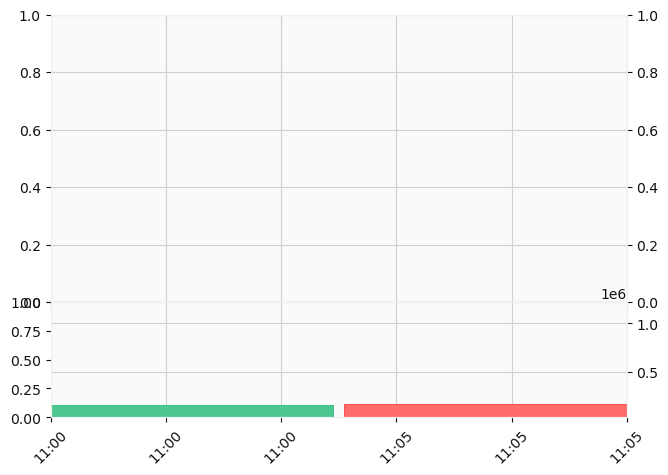

In [4]:
# pull in and store raw dataframe for each stock and offset

os.chdir('C:\\Users\\Chris\\Desktop\\MIDS\\Spring_2022\\STA 663\\Final\\PredictionsFromCandleSticks')

for s in Full_Stock_List:
    
    os.chdir(f'data/labeled_plots/train/{s}')
    # pull data
    ticker = s
    interval = "5Min"
    offset_days = 90 # day to backtest at the end of training model
    num_of_days = (364 * 5) - offset_days # 5 years of data minus backtesting days
    
    train_df, offset_df = pull_data(ticker, interval, api = api_paper, num_of_days = num_of_days, offset_days = offset_days)
    
    # subset data for only during trading hours
    train_df = train_df.between_time('9:29', '15:59')
    offset_df = offset_df.between_time('9:29', '15:59')
    
    # TODO: Scale Data, Scale Plots
    
    # plot and labled training data
    plot_label(train_df, s, window = 24, predict_offset = 2)
    
    os.chdir("../..")
    os.chdir(f'data/labeled_plots/offset/{s}')
    
    # plot and label offset data
    plot_label(offset_df, stock_name, window = 24, predict_offset = 2)
    
    os.chdir('C:\\Users\\Chris\\Desktop\\MIDS\\Spring_2022\\STA 663\\Final\\PredictionsFromCandleSticks')

# APPENDIX

In [2]:
def pull_data(ticker, interval, api = api_paper, num_of_days = 180, offset_days = 0):
    ticker_data_dict = None
    ticker_data_dict = {}
    monthly_data_dict = None
    monthly_data_dict = {}
    interval_loop_data = None
    interval_loop_data = pd.DataFrame()
    stock_data = None
    
    days_to_collect = num_of_days + offset_days

    TZ = 'US/Eastern'

    start = pd.to_datetime((datetime.now() - timedelta(days=days_to_collect)).strftime("%Y-%m-%d %H:%M"), utc=True)
    end = pd.to_datetime(datetime.now().strftime("%Y-%m-%d %H:%M"), utc=True)

    stock_data = api.get_bars(ticker, interval, start = start.isoformat(), end=end.isoformat(), adjustment="raw").df
    
    interval_loop_data = pd.concat([interval_loop_data, stock_data])
    df_start_ref = interval_loop_data.index[0]
    start_str_ref = pd.to_datetime(start, utc=True)

    while start_str_ref.value < ( pd.to_datetime(df_start_ref, utc=True) - pd.Timedelta(days=2.5)).value:
        end_new = pd.to_datetime(interval_loop_data.index[0].strftime("%Y-%m-%d %H:%M"), utc=True).isoformat()
        stock_data_new = None
        stock_data_new = api.get_bars(ticker, interval, start=start, end=end_new, adjustment="raw").df
        #stock_data_new = stock_data_new.reset_index()
        interval_loop_data = interval_loop_data.append(stock_data_new).sort_values(by=['index'], ascending=True)
        df_start_ref = interval_loop_data.index[0]
        
    stock_yr_min_df = interval_loop_data.copy()
    stock_yr_min_df["Open"] = stock_yr_min_df['open']
    stock_yr_min_df["High"]= stock_yr_min_df["high"]
    stock_yr_min_df["Low"] = stock_yr_min_df["low"]
    stock_yr_min_df["Close"] = stock_yr_min_df["close"]
    stock_yr_min_df["Volume"] = stock_yr_min_df["volume"]
    stock_yr_min_df["VolumeWeightedAvgPrice"] = stock_yr_min_df["vwap"]
    stock_yr_min_df["Time"] = stock_yr_min_df.index.tz_convert(TZ)
    stock_yr_min_df.index = stock_yr_min_df.index.tz_convert(TZ)
    final_df = stock_yr_min_df.filter(["Time", "Open", "High", "Low", "Close", "Volume", "VolumeWeightedAvgPrice"], axis = 1)
    
    first_day = final_df.index[0]
    last_day = final_df.index[-1] - pd.Timedelta(days= offset_days)
    training_df =  final_df.loc[:last_day] 
    offset_df =  final_df.loc[last_day:]
    
    return training_df, offset_df

### Importing raw data

In [5]:
train_df, offset_df = pull_data("AMD", "5Min", api_paper, num_of_days = 180, offset_days = 0)

### Building Data Plots

In [4]:
train_df

,Time,Open,High,Low,Close,Volume,VolumeWeightedAvgPrice
timestamp,,,,,,,
2021-10-14 10:20:00-04:00,2021-10-14 10:20:00-04:00,111.0000,111.2400,110.8501,111.1700,712106,111.051553
2021-10-14 10:25:00-04:00,2021-10-14 10:25:00-04:00,111.1650,111.2300,110.9110,110.9300,520095,111.088551
2021-10-14 10:30:00-04:00,2021-10-14 10:30:00-04:00,110.9287,111.1550,110.7200,111.1400,803101,110.944363
2021-10-14 10:35:00-04:00,2021-10-14 10:35:00-04:00,111.1500,111.3300,111.1000,111.2900,688936,111.234813
2021-10-14 10:40:00-04:00,2021-10-14 10:40:00-04:00,111.2911,111.4900,111.1500,111.4800,1332120,111.269463
...,...,...,...,...,...,...,...
2022-04-12 09:55:00-04:00,2022-04-12 09:55:00-04:00,98.9700,99.1200,98.6200,98.8000,1602929,98.901517
2022-04-12 10:00:00-04:00,2022-04-12 10:00:00-04:00,98.8400,99.5900,98.4500,99.4800,2022568,99.127614
2022-04-12 10:05:00-04:00,2022-04-12 10:05:00-04:00,99.4800,99.5200,98.6000,98.8735,1598674,98.954405


In [5]:
fplt.available_styles()

['binance',
 'blueskies',
 'brasil',
 'charles',
 'checkers',
 'classic',
 'default',
 'ibd',
 'kenan',
 'mike',
 'nightclouds',
 'sas',
 'starsandstripes',
 'yahoo']

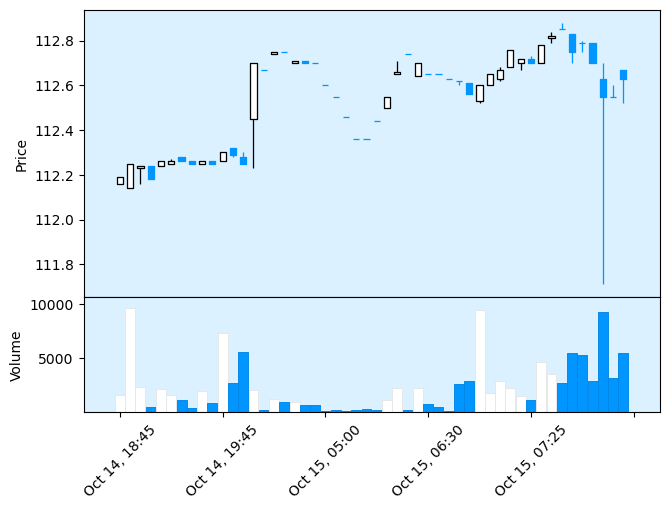

In [6]:
fplt.plot(
            train_df[100:150],
            type='candle',
            style='blueskies',
            volume=True,
            show_nontrading=False
            )

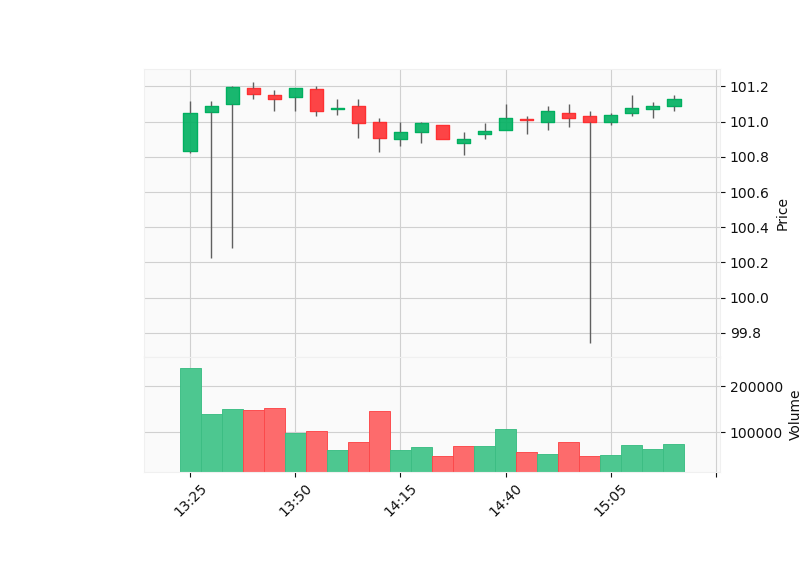

In [33]:
import IPython.display as IPydisplay

plot_df = train_df[125:149].between_time('9:29', '15:59')

fplt.plot(
            plot_df,
            type='candle',
            style='yahoo',
            volume=True,
            savefig="test.png",
            show_nontrading=False
            )

IPydisplay.Image("test.png")

In [8]:
((train_df["Close"][137] - train_df["Close"][136])/train_df["Close"][136]) * 100

0.017754105636925005

In [9]:
train_df["Close"][107] 

112.25

In [10]:
train_df["Close"][106]

112.26

In [44]:
date_ranges = pd.date_range("9:30", "16:00", freq ="5Min").time
print(date_ranges)

[datetime.time(9, 30) datetime.time(9, 35) datetime.time(9, 40)
 datetime.time(9, 45) datetime.time(9, 50) datetime.time(9, 55)
 datetime.time(10, 0) datetime.time(10, 5) datetime.time(10, 10)
 datetime.time(10, 15) datetime.time(10, 20) datetime.time(10, 25)
 datetime.time(10, 30) datetime.time(10, 35) datetime.time(10, 40)
 datetime.time(10, 45) datetime.time(10, 50) datetime.time(10, 55)
 datetime.time(11, 0) datetime.time(11, 5) datetime.time(11, 10)
 datetime.time(11, 15) datetime.time(11, 20) datetime.time(11, 25)
 datetime.time(11, 30) datetime.time(11, 35) datetime.time(11, 40)
 datetime.time(11, 45) datetime.time(11, 50) datetime.time(11, 55)
 datetime.time(12, 0) datetime.time(12, 5) datetime.time(12, 10)
 datetime.time(12, 15) datetime.time(12, 20) datetime.time(12, 25)
 datetime.time(12, 30) datetime.time(12, 35) datetime.time(12, 40)
 datetime.time(12, 45) datetime.time(12, 50) datetime.time(12, 55)
 datetime.time(13, 0) datetime.time(13, 5) datetime.time(13, 10)
 datetime

In [102]:
str(train_df["Time"][0].date())

'2021-10-14'

In [98]:
time(10,30) <= train_df["Time"][0].time() <= time(16,30)

False

In [72]:
train_df["Time"] = train_df.index
train_df[train_df["Time"].between(str(train_df.index.date[2]), str(train_df.index.date[10]))]


,Time,Open,High,Low,Close,Volume,VolumeWeightedAvgPrice
timestamp,,,,,,,


In [ ]:
for date in train_df.index.date:
    print(date)
    print(len(train_df[train_df.index == date]))


In [83]:
train_df.iloc[3]['Time'].hour

10

In [93]:
train_df.Time[1].hour

10

In [90]:
time(9, 30)

datetime.time(9, 30)

In [92]:
train_df.Time[1]

Timestamp('2021-10-14 10:25:00-0400', tz='US/Eastern')

In [107]:
plot_label(train_df, "AMD", window = 6, predict_offset = 2)

AttributeError: 'datetime.date' object has no attribute 'str'